# Import pour data desc

Si on arrive à ces performances on est satisfait :


In [220]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scoring as sc
import seaborn as sns
%matplotlib inline
import importlib
importlib.reload(sc)
import warnings
warnings.simplefilter(action='ignore')


# Import des données et exploration

In [278]:
df = pd.read_csv('data/revenus.csv')
df=df.drop('fnlwgt',axis=1)
df.columns

Index(['age', 'workclass', 'education', 'educational-num', 'marital-status',
       'occupation', 'relationship', 'race', 'gender', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country', 'income'],
      dtype='object')

# Premier cycle :  
## Définition et nomenclature des données 

2. Traiter les données aberrantes 
3. Présenter les liaisons/corrélations avec la variable cible 
4. Entraîner les modèles 
5. Présenter et interpréter les résultats des métriques de qualité

In [222]:
pd.crosstab(df['gender'],df['relationship'])
#4 données abbérantes

relationship,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife
gender,,,,,,
Female,1,5870,689,3376,3928,2328
Male,19715,6713,817,4205,1197,3


In [ ]:
#traitement des données aberrantes
extr=''
for i in df:
    extr+=f'{i} : {df[i].unique()}'+'\n' 
with open('output/vars_and_mods.txt','w') as f :
    f.write(extr)
#Recherche dans chaques variables de modalités qui n'irait pas dedans

Pas de valeurs aberrantes
# Corrélations

https://www.kaggle.com/code/chrisbss1/cramer-s-v-correlation-matrix

<Axes: >

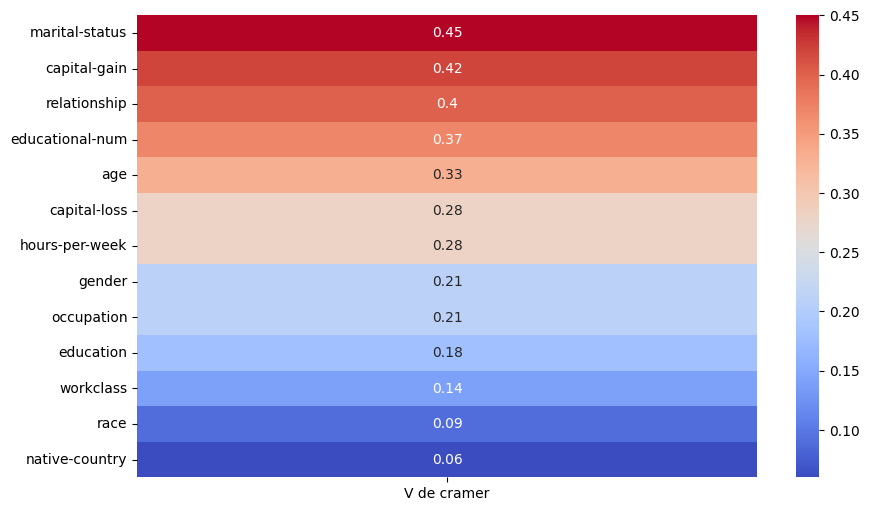

In [224]:
from scipy.stats import chi2_contingency
import numpy as np

df_cramer=pd.get_dummies(df)

def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return np.sqrt(stat/(obs*mini))

rows= []
data={}
for var1 in df_cramer:
  cramers =cramers_V(df_cramer[var1], df_cramer['income_<=50K']) # Cramer's V test
  data[var1]=float(round(cramers,2)) # Keeping of the rounded value of the Cramer's V
sorted_data = dict(sorted(data.items(), key=lambda item: item[1], reverse=True))

# Créer un DataFrame avec les valeurs triées
df_sorted = pd.DataFrame(data=sorted_data, index=['V de cramer'])

#Regrouper le résultat par variables
df_transposed = df_sorted.T.reset_index()
df_transposed['split_index'] = df_transposed['index'].apply(lambda x: x.split('_')[0])
grouped_df = df_transposed.groupby('split_index')['V de cramer'].max()
data={}
for i in range(len(list(grouped_df.index))):
  data[list(grouped_df.index)[i]]=grouped_df.values[i]
sorted_data = dict(sorted(data.items(), key=lambda item: item[1], reverse=True))
df_sorted = pd.DataFrame(data=sorted_data, index=['V de cramer'])
# Afficher le heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_sorted.T[1:], cmap='coolwarm',annot=True)

On supprimera alors native-country, race, workclass et education lors d'un prochain traitement

On remarque que le status de marié est la plus corrélée avec le fait de gagner plus de 50K par mois. BLABLABLA
# Entraîner les modèles

In [225]:
res_all=sc.all_calc(df)

In [226]:
print(sc.fancy_dico(res_all))

Arbre de décision
     accuracy : 0.62 
     auc : 0.74 
     Gauc : 0.53 
     f1-score : 0.61 
Logistique
     accuracy : 0.7 
     auc : 0.71 
     Gauc : 0.72 
     f1-score : 0.58 



# Premier traitement


## REGROUPEMENT ET SUPPRESSION DE VARIABLES

In [280]:
df_regroup=df.copy()
df_regroup['native-country']=df_regroup['native-country'].apply(lambda x : 'USA' if x=='United-States' else 'OTHER')
df_regroup['capital-gain']+=df_regroup['capital-loss']*(-1)
df_regroup=df_regroup.drop('capital-loss',axis=1)
sup_var=[ 'educational-num','native-country', 'race', 'workclass', 'education']
df_regroup=sc.clean_df(df_regroup,sup_var)
sup_reg=['age','fnlwgt','capital-loss','capital-gain','hours-per-week','income']
calc_col=[i for i in df_regroup.columns if i not in sup_var and i!= 'capital-gain' and i!= 'age' and i not in sup_reg]
calc_col.append('income')
interest=['income','>50K']
dico_regroup=[]
for i in range(2):
    dico_regroup.append(sc.regroupement(df_regroup,sup_reg,interest))
    df_regroup=sc.process_datacleaning(df_regroup,dico_regroup[len(dico_regroup)-1])

In [282]:
#Pour voir les regroupements faits par l'algo
with open('output/dico_regroup.txt','w') as f :
    f.write(sc.fancy_dico(dico_regroup))

age


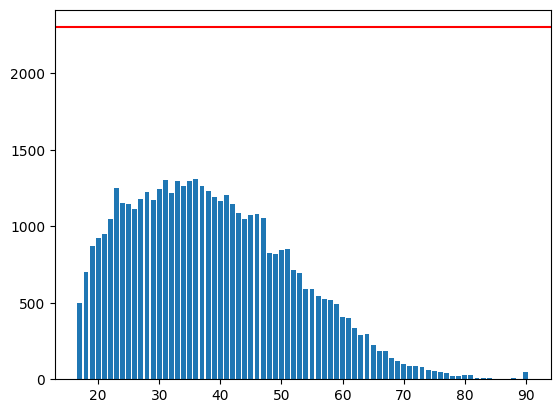

marital-status


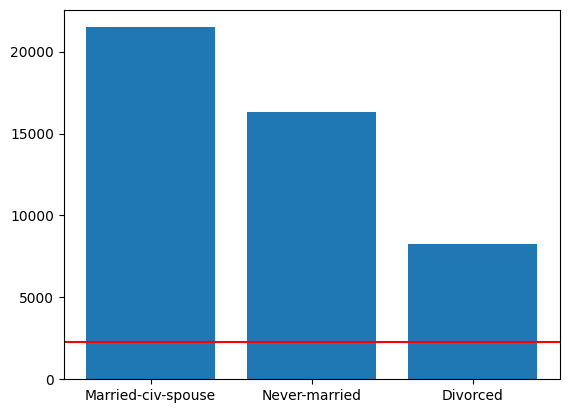

occupation


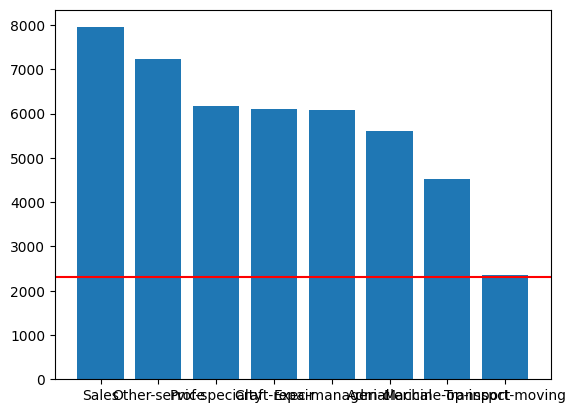

relationship


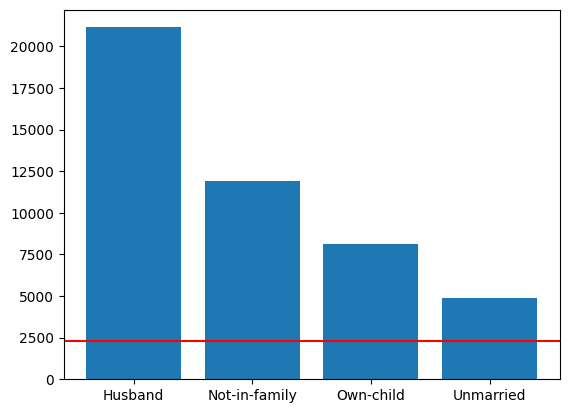

gender


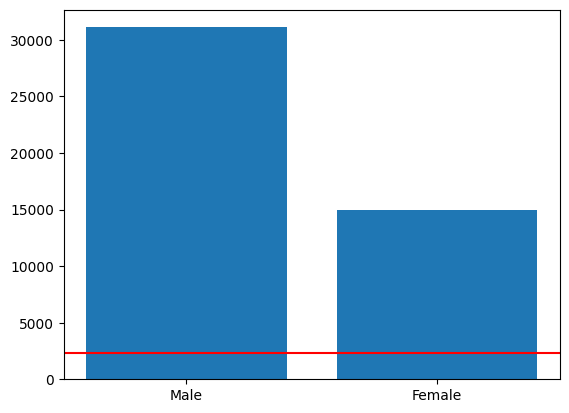

capital-gain


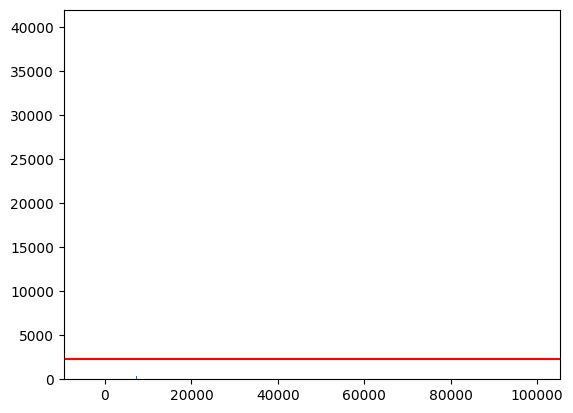

hours-per-week


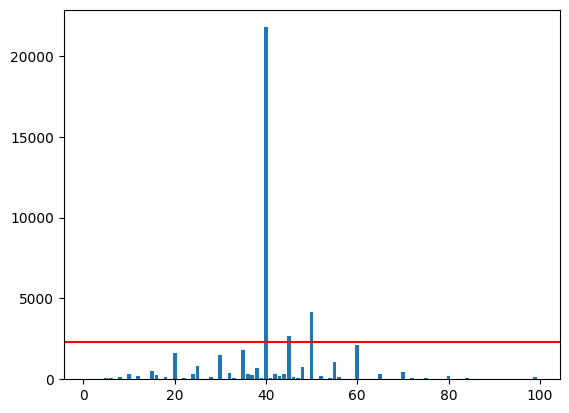

income


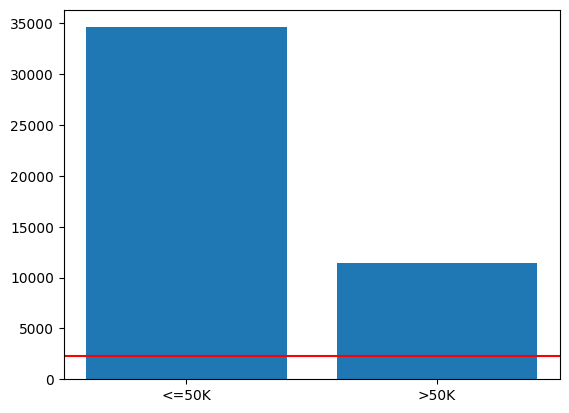

In [283]:
#Pour voir les regroupements faits
sc.show_repartition(df_regroup)

# Comparaison des modèles, nette amélioration

In [265]:
res_reg=sc.all_calc(df_regroup,cols=calc_col)

In [266]:
#Résultats après regroupement et traitement
print(sc.fancy_dico(res_reg))

Arbre de décision
     accuracy : 0.67 
     auc : 0.75 
     Gauc : 0.65 
     f1-score : 0.63 
Logistique
     accuracy : 0.69 
     auc : 0.74 
     Gauc : 0.76 
     f1-score : 0.62 



In [267]:
#Résultats sans traitement
print(sc.fancy_dico(res_all))

Arbre de décision
     accuracy : 0.62 
     auc : 0.74 
     Gauc : 0.53 
     f1-score : 0.61 
Logistique
     accuracy : 0.7 
     auc : 0.71 
     Gauc : 0.72 
     f1-score : 0.58 



# HYPERPARAMETRE TUNING

In [268]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

grid_tree = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}
grid_log={'C': [0.1, 1.0, 10.0, 100.0],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty': ['l2', 'l1']
}
scoring=['roc_auc','f1','accuracy']
n_job=-1
decision_tree=GridSearchCV(DecisionTreeClassifier(),grid_tree,n_jobs=n_job,scoring=scoring,refit='f1')
logit=GridSearchCV(LogisticRegression(max_iter=100),grid_log,n_jobs=n_job,scoring=scoring,refit='f1')
models=[(decision_tree,'Arbre de décision'),(logit,'Logistique')]

In [269]:
sav=sc.all_calc(df_regroup,models,top_cv=True,cols=calc_col)

# Resultats finaux :

In [ ]:
res=[('Sans traitement\n',res_all),('Avec regroupement\n',res_reg),('Regroupement et tunning\n',sav)]
txt=''
for i in res:
    print(i[0],sc.fancy_dico(i[1]),'\n','#'*100)
    txt+=i[0]+' '+sc.fancy_dico(i[1])+'\n'+'#'*100
with open('output/finals_res.txt','w') as f :
    f.write(txt)



Sans traitement
 Arbre de décision
     accuracy : 0.62 
     auc : 0.74 
     Gauc : 0.53 
     f1-score : 0.61 
Logistique
     accuracy : 0.7 
     auc : 0.71 
     Gauc : 0.72 
     f1-score : 0.58 
 
 ####################################################################################################
Avec regroupement
 Arbre de décision
     accuracy : 0.67 
     auc : 0.75 
     Gauc : 0.65 
     f1-score : 0.63 
Logistique
     accuracy : 0.69 
     auc : 0.74 
     Gauc : 0.76 
     f1-score : 0.62 
 
 ####################################################################################################
Regroupement et tunning
 Arbre de décision
     best params : {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10} 
     associed f1-score : {'accuracy': 0.76, 'auc': 0.76, 'Gauc': 0.8, 'f1-score': 0.66} 
Logistique
     best params : {'C': 10.0, 'penalty': 'l2', 'solver': 'lbfgs'} 
     associed f1-score : {'accuracy': 0.69, 'auc': 0.74, 'Gauc':

In [292]:
%pip install pygments

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\lenovo\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# PREDICTION AVEC LA NOUVELLE DATA

In [ ]:
importlib.reload(sc)
df_newdata=pd.read_csv('data/nouvelle_data.csv')
df_newdata=df_newdata.drop('fnlwgt',axis=1
                           )
df_newdata['native-country']=df_newdata['native-country'].apply(lambda x : 'USA' if x=='United-States' else 'OTHER')
df_newdata['capital-gain']+=df_newdata['capital-loss']*(-1)
df_newdata=df_newdata.drop('capital-loss',axis=1)
df_newdata=df_newdata.drop(df_newdata[df_newdata['workclass']=='Never-worked'].index) #Parce que nous avons supprimé tout ce qui avait des ?
df_newdata=sc.clean_df(df_newdata,sup_var)
for i in range(5):
    df_newdata=sc.process_datacleaning(df_newdata,dico_regroup[i])

In [276]:
prediction=sc.all_calc(df_regroup,new_data=df_newdata,models=models,cols=calc_col)
prediction

{'Arbre de décision': [array([False, False,  True, ...,  True, False, False]),
  'Arbre de décision'],
 'Logistique': [array([False, False,  True, ..., False, False, False]),
  'Logistique']}

In [277]:
df_newdata['Pred_Logit']=prediction['Logistique'][0]
df_newdata['Pred_Arbre']=prediction['Arbre de décision'][0]
df_newdata.to_csv('df_pred_newdata.csv')